# Импорт

In [1]:
import gc
import os

import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier

# Обработка данных

Считывание данных о контрактах

In [2]:
contract_path = os.path.abspath('C:\csv\contracts.csv')
dtypes = {'product_code' : 'category', 
          'customer_legal_form' : 'category', 
          'supplier_legal_form' : 'category', 
          'current_contract_stage' : 'category'}
parse_dates = ['execution_period_start']
data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
gc.collect()
data['execution_period_start'] = pd.to_datetime(data['execution_period_start'], format = "%Y-%m-%d", errors = 'coerce')
data['execution_period_end'] = pd.to_datetime(data['execution_period_end'], format = "%Y-%m-%d", errors = 'coerce')
data.head()

C:\Users\Данил\AppData\Local\Temp\ipykernel_12700\3439507682.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
C:\Users\Данил\AppData\Local\Temp\ipykernel_12700\3439507682.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)


,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage
0,39372925,2056104253518000008,2018-01-18T12:25:48.307+03:00,561042535,75203,72500.00,2018-01-18,2018-03-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,561046931,E
1,39141990,2056104253517000135,2018-01-12T11:41:48.714+03:00,561042535,75203,991142.46,2017-10-24,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,561046931,E
2,39452733,2056203249818000006,2018-01-23T09:12:49.012+03:00,562032498,75203,170000.00,2018-01-22,2018-03-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,NaN,56207573829,E
3,39762144,1057000290918000009,2018-01-31T18:50:01.658+03:00,570002909,75104,200000.00,2018-01-29,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,545019120,E
4,39348176,2056207055018000003,2018-01-17T16:47:12.637+03:00,562070550,75204,6393010.00,2017-06-20,2017-09-30,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,506066768,E


In [3]:
data = data.dropna()

In [4]:
data = data[(data['execution_period_start'] >= pd.Timestamp(2014,1,1))]

In [5]:
OKOPF_old = {
    '12100' : '10000',
    '12165' : '12300', #Общества с ограниченной ответственностью
    '12166' : '10000',
    '15000' : '65000', #Унитарные предприятия
    '15100' : '65100',  #Унитарные предприятия, основанные на праве оперативного управления (казенные предприятия)
    '15141' : '65141', #Федеральные казенные предприятия
    '15142' : '65142', #Казенные предприятия субъектов Российской Федерации
    '15143' : '65143', #Муниципальные казенные предприятия
    '15200' : '65200', #Унитарные предприятия, основанные на праве хозяйственного ведения
    '15241' : '65241', #Федеральные государственные унитарные предприятия
    '15242' : '65242', #Государственные унитарные предприятия субъектов Российской Федерации
    '15243' : '65243', #Муниципальные унитарные предприятия
    '20114' : 'Not Applicable',
    '20300' : '71500',
    '20400' : '70400', #Фонды
    '20401' : '70401', #Благотворительные фонды
    '20402' : '70402', #Негосударственные пенсионные фонды
    '20403' : '70403', #Общественные фонды
    '20404' : '70404', #Экологические фонды
    '20500' : '20614', #Некоммерческие партнерства
    '20617' : 'Not Applicable',
    '20618' : 'Not Applicable',
    '20701' : '20702',
    '20800' : '20600',
    '20801' : '20609',
    '20802' : '20610',
    '20803' : '20611',
    '20810' : '21200',
    '20816' : '20716',
    '20900' : '75000', #Учреждения
    '20901' : '75000', #Автономные учреждения -> Учреждения, из-за подразделения на уровни в новом ОКОПФ
    '20902' : '75502', #Благотворительные учреждения
    '20903' : '75000', #Бюджетные учреждения, Аналогично Автономным учреждениям
    '20904' : '75000', #Казеннные учреждения, Аналогично Автономным учреждениям
    '20905' : '75505', #Общественные учреждения
    '20906' : '75500', #Учреждения
    '20907' : '75000', #Учреждения акакдемий наук, в новом классификаторе такая категория отсутсвует поэтому переставляем на более общую категорию
    '20908' : '75000', #Учреждения религиозных организаций, в новом классификаторе такая категория отсутсвует поэтому переставляем на более общую категорию
    '21001' : '20701', #Садоводческие, огороднические или дачные некоммерческие товарищества
    '28000' : 'Not Applicable',   #Иные Некоммерческие организации
    '28001' : '71400', #Автономные некоммерческие организации
    '28002' : '20615',
    '28003' : '75300',
    '28004' : '71602', #Государственные компании
    '28005' : '71601', #Государственные корпорации
    '28006' : '21100', #Казачьи общества -> Казачьи общества, внесенные в государственный реестр казачьих обществ в Российской Федерации
    '28007' : '20616',
    '28008' : '20108',
    '28010' : '21200',
    '28012' : '20612',
    '28013' : 'Not Applicable',
    '28014' : '71610',
    '28016' : '20716',
    '28017' : '20217', #Территориальные общественные самоуправления
    '29000' : 'Not Applicable',   #Иные Некоммерческие организации
}

In [6]:
data['customer_legal_form'] = data['customer_legal_form'].map(OKOPF_old).fillna(data['customer_legal_form'])
data = data[data['customer_legal_form'] != 'Not Applicable']

In [7]:
data['supplier_legal_form'] = data['supplier_legal_form'].map(OKOPF_old).fillna(data['supplier_legal_form'])
data = data[data['supplier_legal_form'] != 'Not Applicable']

In [8]:
data = data[(data['price'] > 0)]

In [9]:
len(data)

13878043

In [10]:
data = data[(data['current_contract_stage'] != "E")]

In [11]:
data

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage
611,39461574,2057100353517000005,2018-01-23T09:05:46.693+03:00,571003535,75204,8624124.69,2017-08-03,2017-11-30,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,250015377,EC
648,39098703,3054501142717000005,2018-01-12T18:13:32.908+03:00,545011427,75404,601773.01,2017-03-20,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,554002010,ET
2328,54980736,2054103082019000004,2020-01-21T16:53:45.142+03:00,541030820,75204,27266.70,2019-01-01,2019-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12247,7707049388,ET
2791,52419225,3051500439819000022,2020-01-10T10:32:10.567+03:00,515004398,75404,6956744.00,2019-08-05,2019-11-04,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,572005648,EC
5182,34304111,1054100113917000053,2017-05-25T16:35:31.117+03:00,541001139,75104,275500.00,2017-05-19,2017-05-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,573005344,EC
...,...,...,...,...,...,...,...,...,...,...,...,...
16479529,43118032,2410108906617000042,2018-07-13T12:02:20.885+12:00,4101089066,75203,39513.00,2017-04-12,2017-12-30,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,2724069628,EC
16479585,43117848,2410108906616000077,2018-07-13T10:38:01.303+12:00,4101089066,75203,200356.40,2017-01-01,2018-01-11,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4101143429,EC
16479587,43117857,2410108906616000079,2018-07-13T11:26:23.670+12:00,4101089066,75203,266527.36,2017-01-01,2018-01-11,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4105045253,EC
16479621,43118777,2410108906617000063,2018-07-13T23:15:54.416+12:00,4101089066,75203,28200.00,2017-10-11,2018-01-29,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,2539115020,EC


Из системы госзакупок:
*   EC - Завершен
*   E - Выполяется
*   ET - Исполнение прекращено
*   IN - Контракт Аннулирован

Добавленные:
*   Unknown - Результат неизвестен

# Обучение

In [12]:
def calculate_time_period(row):
  return ((row['execution_period_end'] - row['execution_period_start']).days + 1)

data['time'] = data[['execution_period_end', 'execution_period_start']].apply(calculate_time_period, axis=1)
gc.collect()

0

In [13]:
print("EC", len(data[data['current_contract_stage']=='EC']))
print("ET", len(data[data['current_contract_stage']=='ET']))

EC 37461
ET 6541


In [14]:
data.sort_values('execution_period_start', inplace = True)

In [15]:
ec = data[(data['current_contract_stage']=='EC')]
et = data[(data['current_contract_stage']=='ET')]

In [16]:
def train_test_split(data, percent=20):
    last = data.tail(round(len(data) * (percent/100)))
    first = data.head(round(len(data) * (1 - (percent/100))))
    return first, last

In [17]:
x_ec = ec.copy()
y_ec = x_ec[['current_contract_stage', 'execution_period_start']]
x_ec = x_ec.drop(['reg_num', 'publish_date', 'customer_inn', 'execution_period_end', 'supplier_inn', 'id'], axis=1)
x_train_ec, x_test_ec = train_test_split(x_ec)
y_train_ec, y_test_ec = train_test_split(y_ec)

In [18]:
x_et = et.copy()
y_et = x_et[['current_contract_stage', 'execution_period_start']]
x_et = x_et.drop(['reg_num', 'publish_date', 'customer_inn', 'execution_period_end', 'supplier_inn', 'id'], axis=1)
x_train_et, x_test_et = train_test_split(x_et)
y_train_et, y_test_et = train_test_split(y_et)

In [19]:
x_train = pd.concat([x_train_ec, x_train_et], ignore_index=True)
y_train = pd.concat([y_train_ec, y_train_et], ignore_index=True)
x_test = pd.concat([x_test_ec, x_test_et], ignore_index=True)
y_test = pd.concat([y_test_ec, y_test_et], ignore_index=True)

In [20]:
x_train = x_train.sort_values('execution_period_start').reset_index(drop=True)
y_train = y_train.sort_values('execution_period_start').reset_index(drop=True)
x_test = x_test.sort_values('execution_period_start').reset_index(drop=True)
y_test = y_test.sort_values('execution_period_start').reset_index(drop=True)

In [21]:
#Балансировка тренировочных данных
old_indexes = round(len(x_train[x_train['current_contract_stage']=='EC'])
 - len(x_train[x_train['current_contract_stage']=='ET']))
x_train.sort_values('current_contract_stage', inplace = True)
x_train = x_train.reset_index(drop=True)
x_train.drop(x_train[((x_train.index < old_indexes) & (x_train['current_contract_stage']=="EC"))].index, inplace=True)

y_train.sort_values('current_contract_stage', inplace = True)
y_train = y_train.reset_index(drop=True)
y_train.drop(y_train[((y_train.index < old_indexes) & (y_train['current_contract_stage']=="EC"))].index, inplace=True)
gc.collect()

0

In [22]:
x_train = x_train.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_train = y_train.drop(['execution_period_start'], axis=1)
x_test = x_test.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_test = y_test.drop(['execution_period_start'], axis=1)

In [23]:
del x_train_ec, x_train_et, y_train_ec, y_train_et, x_ec, x_et, y_ec, y_et
gc.collect()

0

In [24]:
print("EC", len(y_test[y_test['current_contract_stage']=='EC']))
print("ET", len(y_test[y_test['current_contract_stage']=='ET']))

EC 7492
ET 1308


In [25]:
print("EC", len(y_train[y_train['current_contract_stage']=='EC']))
print("ET", len(y_train[y_train['current_contract_stage']=='ET']))

EC 5233
ET 5233


              precision    recall  f1-score   support

          EC       0.88      0.76      0.81      7492
          ET       0.22      0.39      0.28      1308

    accuracy                           0.70      8800
   macro avg       0.55      0.57      0.55      8800
weighted avg       0.78      0.70      0.73      8800



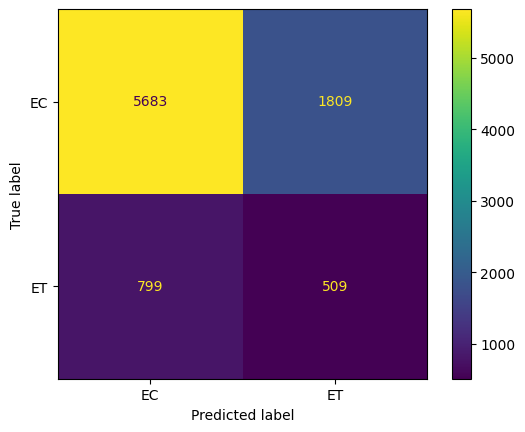

In [27]:
cat_features = ['customer_legal_form', 'product_code', 'supplier_legal_form']
model_catboost = CatBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.01,
    max_depth = 5,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

In [ ]:
#значимость признаков для леса
importances = model_catboost.best_estimator_.get_feature_importance()
indices = np.argsort(importances)[::-1]
col = x_train.columns
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

In [ ]:
model_catboost.save_model(os.path.relpath("resources/catboost"))

История исполнителя

In [153]:
data

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,time
3197045,19270183,118100008913000357,2015-01-20T19:20:39.990+03:00,2309090540,75000,77703.52,2014-01-01,2014-12-31,40.30.10.174,12247,7708503727,EC,365
10679151,19409401,348100019114000002,2015-01-27T09:19:39.159+03:00,5027106892,75000,317583.72,2014-01-01,2015-01-30,40.12.10.110,12247,7736520080,EC,395
3465486,19171403,318100039514000024,2015-01-15T18:37:05.311+03:00,2320172500,75000,2640736.36,2014-01-01,2014-12-01,41.00.20.132,12300,2320210667,EC,335
3465635,19167992,318100039514000027,2015-01-15T18:09:33.929+03:00,2320172500,75000,280300.17,2014-01-01,2015-03-31,40.11.10.115,75000,7704191019,EC,455
3466133,19227177,318100039514000027,2015-01-18T09:37:03.654+03:00,2320172500,75000,395674.49,2014-01-01,2015-03-31,40.11.10.115,75000,7704191019,EC,455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716077,62776870,3190112923420000075,2021-01-19T11:19:14.402+07:00,1901129234,75404,178274.58,2020-12-16,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,1901064509,ET,16
11322441,62699617,2072500547920000048,2021-01-18T16:23:00.471+03:00,725005479,75203,112798.41,2020-12-21,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,11
16385913,62890320,2410117900920000009,2021-01-29T16:19:33.513+12:00,4101179009,75203,240000.00,2020-12-21,2021-03-22,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,2722050371,EC,92
12751051,62529379,3032333944020000147,2021-01-13T09:55:55.164+08:00,323339440,75404,937491.84,2020-12-25,2021-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,326540932,EC,372


In [155]:
supp = data[(data['supplier_inn'] == 726016530)]

In [156]:
print("Хорошо проведенные:",  len(supp[(supp['current_contract_stage'] == 'EC')]))

Хорошо проведенные: 19


In [157]:
print("Так себе проведенные:",  len(supp[(supp['current_contract_stage'] == 'ET')]))

Так себе проведенные: 4


In [158]:
supp

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,time
11211860,31887551,2071103152816000003,2017-01-23T18:29:55.688+03:00,711031528,75204,143094.13,2016-11-30,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,397
11309210,37858805,2072106342316000022,2017-12-05T16:10:48.072+03:00,725009184,75204,133934.73,2016-12-14,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,ET,383
11281166,39681638,3071104297817000004,2018-01-30T18:03:52.166+03:00,711042978,75404,783638.63,2017-01-01,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,365
11228722,41900166,3071104333017000021,2018-05-14T11:52:08.186+03:00,711043330,75404,3928955.36,2017-02-13,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,322
11325935,41900166,3071104333017000021,2018-05-14T11:52:08.186+03:00,711043330,75404,3928955.36,2017-02-13,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,322
11260746,40956869,1071102644717000020,2018-04-03T16:20:43.693+03:00,711026447,30002,522737.48,2017-05-29,2017-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,217
11295140,39568890,2072501475517000012,2018-01-25T12:15:10.753+03:00,725014755,75204,68718.39,2017-09-28,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,ET,460
11229892,46337997,3071104352318000005,2018-12-28T20:47:47.819+03:00,711043523,75404,1714771.30,2018-01-01,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,365
11228991,46337997,3071104352318000005,2018-12-28T20:47:47.819+03:00,711043523,75404,1714771.30,2018-01-01,2018-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,365
11269693,50244719,2071104232918000003,2019-06-20T19:02:40.100+03:00,711042329,75203,124644.59,2018-01-01,2019-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,65243,726016530,EC,730


In [159]:
data[data['current_contract_stage']=='ET']

,id,reg_num,publish_date,customer_inn,customer_legal_form,price,execution_period_start,execution_period_end,product_code,supplier_legal_form,supplier_inn,current_contract_stage,time
1339366,19424560,369100012414000023,2015-01-27T09:38:27.156+05:00,7453140707,75000,19000.00,2014-01-01,2014-12-31,64.20.11.113,12247,7707049388,ET,365
3394970,18652463,318300336414000002,2015-01-14T14:09:40.279+03:00,2346014138,75000,288.36,2014-01-01,2015-01-13,64.20.12.133,12247,7707049388,ET,378
15340201,19362351,387300062613000130,2015-01-23T16:11:01.972+05:00,8623001078,75000,738190.35,2014-01-01,2015-01-31,15.33.25.125,12300,8602021468,ET,396
3394917,15763889,318200049214000002,2015-01-28T14:33:34.742+03:00,2310120340,75000,446704.91,2014-01-01,2014-12-31,64.20.14.000,12247,7707049388,ET,365
15949976,31769878,340100017314000003,2017-01-28T19:16:56.042+03:00,4322012086,75104,501223.01,2014-01-01,2016-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12200,5612042824,ET,1096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13115102,62200966,3424000680720000010,2020-12-28T15:54:39.692+07:00,4240006807,75403,141692.96,2020-11-18,2020-12-30,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,4205262886,ET,43
11829127,62614308,3381901087120000013,2021-01-15T08:29:33.882+08:00,3819010871,75403,46620.00,2020-11-23,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12267,3840001848,ET,39
10049075,61614844,3504009579120000016,2020-12-28T12:51:46.637+03:00,5040095791,75403,101569.26,2020-11-24,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12300,7724364407,ET,38
11828822,62652893,3381901087120000014,2021-01-18T08:10:22.099+08:00,3819010871,75403,134760.44,2020-11-26,2020-12-31,<Element '{http://zakupki.gov.ru/oos/types/1}c...,12267,3840001848,ET,36
